<a href="https://colab.research.google.com/github/bapronx/valeurs_foncieres/blob/master/valeurs_foncieres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyse des valeurs foncières

Dans sa démarche d'open data, le gouvernement à inauguré en avril 2019 un site présentant les données de transactions immobilières enregistrées par les notaires.

J'explore quelques unes de ces données dans ce notebook, en essayant de combiner une partie de modélisation / ML sur le prix au m², et des outils interactifs de visualisations des transactions, avec le plan suivant:

[1- Téléchargement et analyse des données](#p1)

2- Géocodage

3- Analyse des données avec feature géographiques

Le code complet est disponible sur le github https://github.com/bapronx/valeurs_foncieres



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


<a id='p1'> </a>

## 1 - Téléchargement et analyse

###a- Téléchargement et filtrage

Si déjà effectué, possibilité d'uploader le dataframe directement à la section suivante

In [225]:

!wget https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346
fname = "1be77ca5-dc1b-4e50-af2b-0240147e0346"
fid = open(fname, 'r')
df=pd.read_csv(fname,sep='|')
fid.close()

def show_cols(df):
  """ show summary of a dataframe """
  print(" Colonnes dans le fichier :\n " + "-"*20 + "\n" +  "\n".join(["{:2d} || {:30s} : {} ".format(k,n,t) for k,(n,t) in enumerate(zip(df.columns,df.dtypes))]))
  print ("-"*20)
  print(" Nombres de transaction enregistrées : \n " + "-"*20 + "\n{}".format(len(df)))

show_cols(df)

--2019-08-20 09:33:26--  https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.73
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.73|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://static.data.gouv.fr/resources/demande-de-valeurs-foncieres/20190417-121621/valeursfoncieres-2018.txt [following]
--2019-08-20 09:33:26--  https://static.data.gouv.fr/resources/demande-de-valeurs-foncieres/20190417-121621/valeursfoncieres-2018.txt
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.73
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311574861 (297M) [text/plain]
Saving to: ‘1be77ca5-dc1b-4e50-af2b-0240147e0346.2’

1be77ca5-dc1b-4e50- 100%[===================>] 297.14M  21.8MB/s    in 17s     

2019-08-20 09:33:44 (17.4 MB/s) - ‘1be77ca5-dc1b-4e50-af2b-024014

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,18,23,24,26,28,31,32,33,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


 Colonnes dans le fichier :
 --------------------
 0 || Code service CH                : float64 
 1 || Reference document             : float64 
 2 || 1 Articles CGI                 : float64 
 3 || 2 Articles CGI                 : float64 
 4 || 3 Articles CGI                 : float64 
 5 || 4 Articles CGI                 : float64 
 6 || 5 Articles CGI                 : float64 
 7 || No disposition                 : int64 
 8 || Date mutation                  : object 
 9 || Nature mutation                : object 
10 || Valeur fonciere                : object 
11 || No voie                        : float64 
12 || B/T/Q                          : object 
13 || Type de voie                   : object 
14 || Code voie                      : object 
15 || Voie                           : object 
16 || Code postal                    : float64 
17 || Commune                        : object 
18 || Code departement               : object 
19 || Code commune                   : int64 
20 

Il convient d'abord de faire un tri parmi les colonnes, en ne gardant que celles d'intérêt à notre étude dans un premier temps, et en reformatant les contenus pour des types plus homogènes

In [3]:
def process_string(s):
  """ Change coma in point for french float convention issues
  """
  if isinstance(s, str):
    return float(s.replace(',', '.'))
  else:
    return s
  
def clean_str_nan(s):
  """ remove floats and nan values from string columns
  """
  if isinstance(s, float) and np.isnan(s):
      return ""
  return s


def remove_out(d, nsigma=2):
  """ Try and remove outliers from a distribution
  input:
    d (pd.DataFrame) : Dataframe
    nsigma (int) : number of std deviation to allow around median
  
  output:
    df (pd.DataFrame): filtered Dataframe
    selec (bool) : boolean list such as df = d[selec]
    
  """
  m = d.median()
  s = np.abs(d-m).median()
  selec = (d<=(m+nsigma*s)) & (d>=(m-nsigma*s))
  return d[selec], selec


#Reformating of columns that should be floats
key_to_proc = ("Valeur fonciere", "Surface reelle bati", "Code postal")
for key in key_to_proc:
    df[key] = df[key].apply(process_string)
df.rename(columns={"Surface reelle bati":"surface", "Valeur fonciere":"prix"}, inplace=True)
df["Code postal"][np.isnan(df["Code postal"])]=-9999

#Reformating of columns that should be strings
df["Type de voie"] = df["Type de voie"].apply(clean_str_nan)
df["Voie"] = df["Voie"].apply(clean_str_nan)

keys_of_interest = ["surface", "prix", "Type de voie", "Voie", "Code postal", "Type local", "Code departement", "Commune", "No voie"]
df = df[keys_of_interest]

#drop na
keys_of_no_na = ["surface", "prix"]
df.dropna(subset=keys_of_no_na, inplace=True)

#drop 0 surface
df = df[df["surface"]>0]

#Add ratio column
df["prix au m2"] = df["prix"] / df["surface"]


show_cols(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 Colonnes dans le fichier :
 --------------------
 0 || surface                        : float64 
 1 || prix                           : float64 
 2 || Type de voie                   : object 
 3 || Voie                           : object 
 4 || Code postal                    : float64 
 5 || Type local                     : object 
 6 || Code departement               : object 
 7 || Commune                        : object 
 8 || No voie                        : float64 
 9 || prix au m2                     : float64 
--------------------
 Nombres de transaction enregistrées : 
 --------------------
921573


Pour le moment, on sélectionne seulement les appartements parisiens

In [0]:

selec = (df["Type local"]=="Appartement") & (df["Code departement"]==75)
prix_paris, subselec_paris = remove_out(df["prix au m2"][selec])

selec[selec] = subselec_paris
paris_df = df[:][selec]
paris_df.to_pickle("paris_dataframe.pkl")


### a- bis Chargement d'un pickle existant


In [0]:
from google.colab import files
uploaded = files.upload()    
 


Saving paris_dataframe.pkl to paris_dataframe (2).pkl


KeyboardInterrupt: ignored

In [0]:
import pickle
uploaded_pickles = []
uploaded = {"paris_dataframe.pkl":"paris_dataframe.pkl"}
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  try:
    with open(fn, 'rb') as file:
      el = pickle.load(file)
      uploaded_pickles.append(el)
    print("{name} loaded correctly as {type}".format(name=fn, type=type(el)))
  except:
    print("failed to load {} (not a pickle ?)".format(fn))

User uploaded file "paris_dataframe.pkl" with length 19 bytes
paris_dataframe.pkl loaded correctly as <class 'pandas.core.frame.DataFrame'>


In [0]:
paris_df = uploaded_pickles[0]

### b- Analyse

On a à présent un subset des prix des appartements parisiens les plus représentatifs.

On peut commencer par regarder la répartition des prix, à l'échelle de la ville :

Ensemble des données :
Histogramme des prix au m²


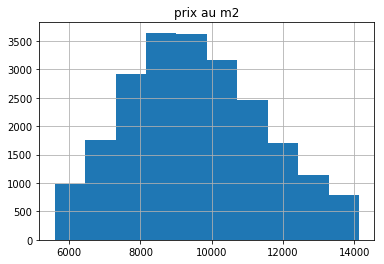

In [0]:
print("Histogramme des prix au m²")
_ = paris_df.hist(column="prix au m2")

Et des arrondissements :

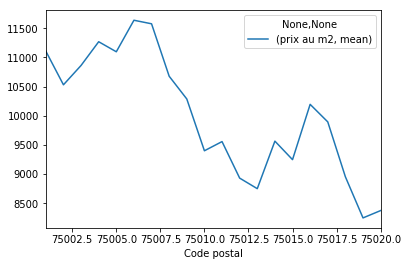

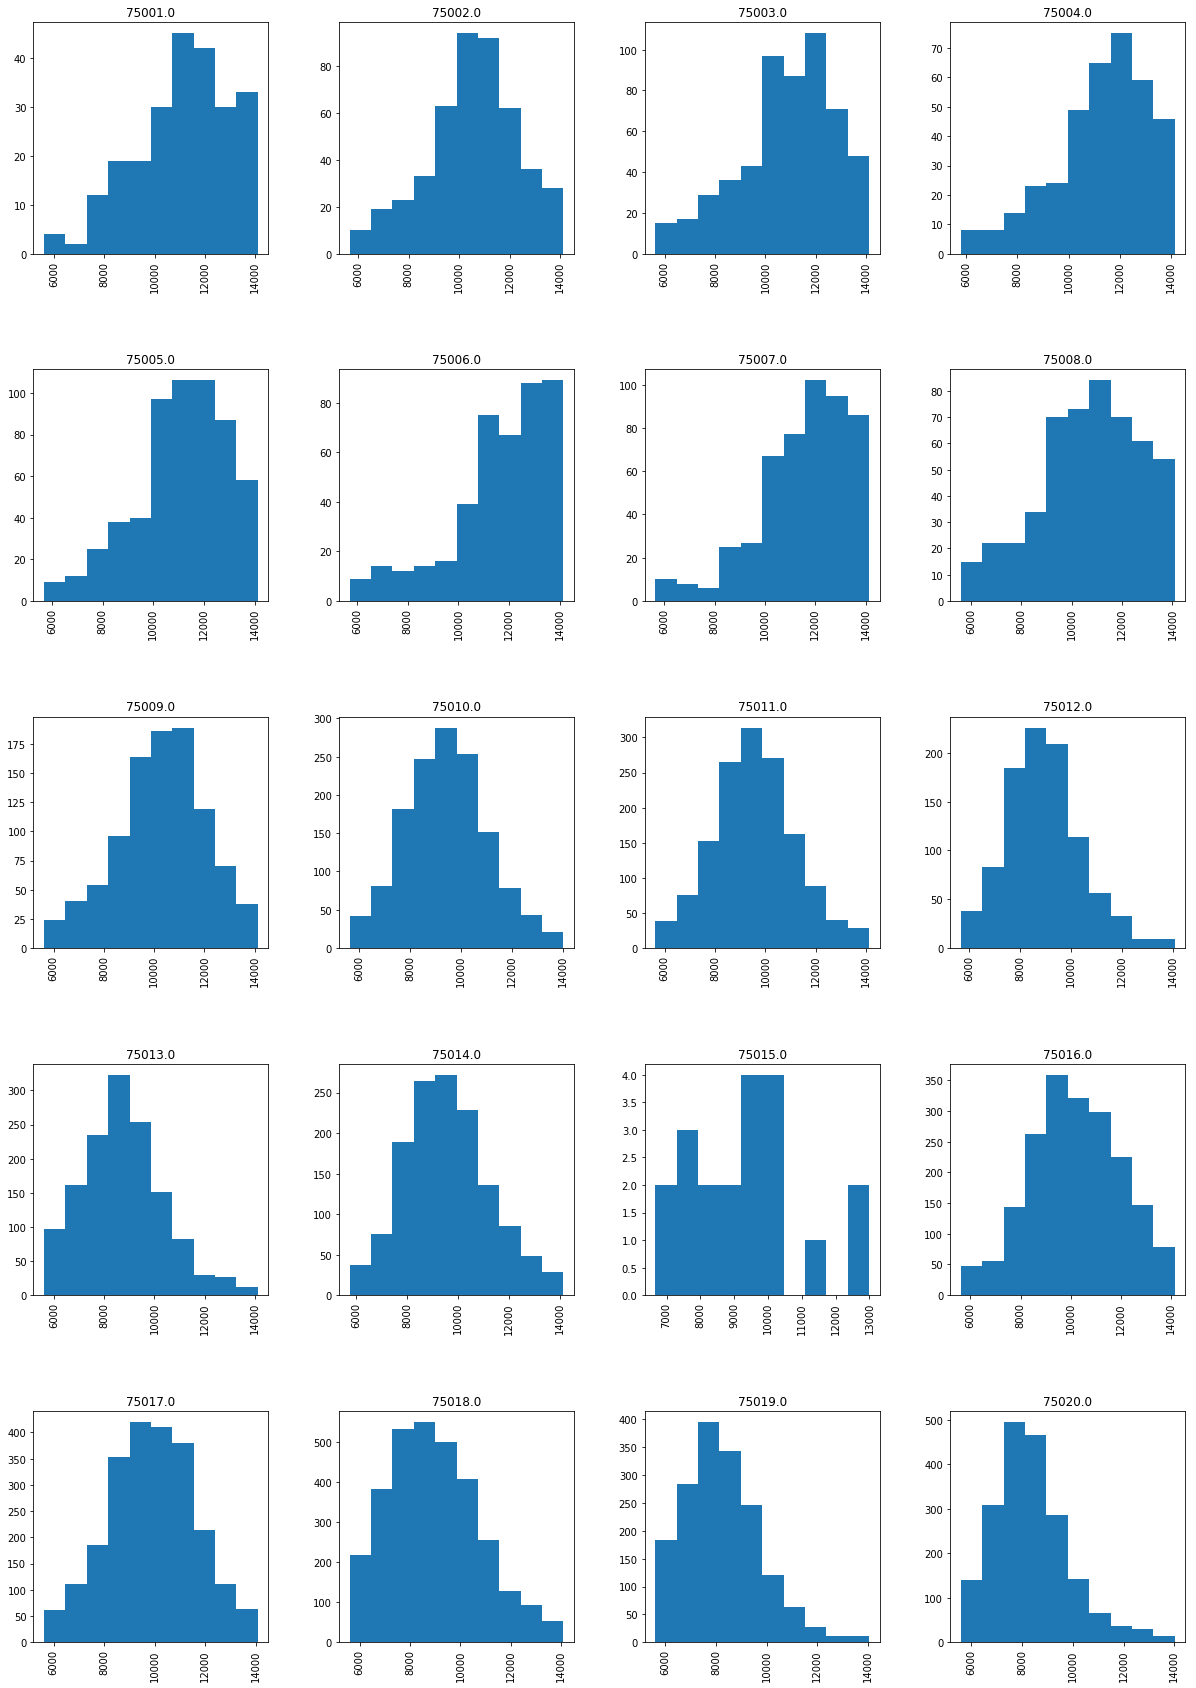

In [0]:
paris_df.groupby(["Code postal"])[["prix au m2"]].agg(["mean"]).plot()
_= paris_df.hist(column="prix au m2", by=["Code postal"], figsize=(20,30))

Outre la variation des prix par arrondissement, qui colle bien avec le marché immobilier, on remarque deux choses :

1.   la répartition des prix dans chaque arrondissement semble bien normalement distribuée
2.   on manque de données pour le 15e arrondissement

Regardons pour finir le classement des arrondissements du plus onéreux au moins cher :



In [223]:
#print(paris_df.groupby(["Code postal"])[["prix au m2"]].agg(["count"]))
print("Classement des arrondissements par prix au m²:")
print(paris_df.groupby(["Code postal"])[["prix au m2"]].agg(["mean"]).sort_values(by=("prix au m2", "mean"), ascending=False))

Classement des arrondissements par prix au m²:
               prix au m2
                     mean
Code postal              
75006.0      11636.772323
75007.0      11575.915029
75004.0      11268.507753
75001.0      11107.408940
75005.0      11096.566585
75003.0      10862.250111
75008.0      10677.469585
75002.0      10530.685057
75009.0      10287.712811
75016.0      10195.709563
75017.0       9895.219138
75014.0       9565.432633
75011.0       9557.514362
75010.0       9400.345954
75015.0       9248.211470
75018.0       8954.524599
75012.0       8931.866345
75013.0       8750.987359
75020.0       8375.642817
75019.0       8249.748262


##2- Géocoding

Pour commencer des modélisations allant au delà des attributs statistiques standards, il est nécessaire d'enrichir les données pour leur ajouter une composante spatiale exploitable.

On s'appuie ici sur l'API Mapquest pour transformer les adresses en coordonnées UTM.

Comme précédemment, on peut passer cette étape en uploadant directement le résultat s'il est disponible

In [0]:
def line_to_location_string(serie):
  """ Combine the different dataframe fields to a coherent address
  """
  number = serie["No voie"]
  if number.is_integer():
    number = str(int(number))
  else:
    number = ""
  return ", ".join(["France", \
      serie["Commune"], \
      ("%05i" % (serie["Code postal"],)), \
        " ".join([ number, serie["Type de voie"], serie["Voie"]])])

def get_all_location_string(df):
  """ Return all unique adresses in the dataframe
  """
  location = df.apply(line_to_location_string, axis=1)
  return location.unique()

all_loc = get_all_location_string(paris_df)

###Complet (passer si upload possible)
Requête des données sur MapQuest

In [0]:
import os
if not os.path.exists("batches"):
  os.mkdir("batches")

key = input("input API key: \n")
url = "http://www.mapquestapi.com/geocoding/v1/batch"

def submit_data(locations):
    """ Use mapquest api to request GPS coordinates from the address
    """
    dico = {"maxResults":1, "location":locations, "key":key}
    req = requests.get(url, params=dico)
    return json.loads(req.text)['results']
    
def batch_maker(loc_list, batch_size=100):
  """ generate batches of batch_size adresses to feed the batch API
  """
  n_batch = int(ceil(len(loc_list) / batch_size))
  for k_batch in range(n_batch):
    yield loc_list[k_batch*batch_size:min((k_batch+1)*batch_size, len(loc_list))]

for kb, batch in enumerate(batch_maker(all_loc)):
  gps_loc = submit_data(batch)
  latlong = [ a["locations"][0]["latLng"] for a in gps_loc]
  batch_lat = [a["lat"] for a in latlong]
  batch_long = [a["lng"] for a in latlong]
  batch_df=pd.DataFrame({"location":batch, "lat":batch_lat, "long":batch_long})
  batch_df.to_pickle("batches/batch_{}.pkl".format(kb))
  
blist = os.listdir("batches")
all_df = None
for bfile in blist:
  batch_df = pd.read_pickle("batches/"+bfile)
  if all_df is None:
    all_df = batch_df
  else:
    all_df = pd.concat((all_df, batch_df), ignore_index=True)
all_df.to_pickle("paris_unique_locations_df.pkl")

### Upload

In [6]:
from google.colab import files
uploaded = files.upload()



Saving paris_unique_locations_df.pikl to paris_unique_locations_df.pikl


In [7]:
import pickle
uploaded_pickles = []
uploaded = {"paris_unique_locations_df.pikl":"paris_unique_locations_df.ipkl"}
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  try:
    with open(fn, 'rb') as file:
      el = pickle.load(file)
      uploaded_pickles.append(el)
    print("{name} loaded correctly as {type}".format(name=fn, type=type(el)))
  except:
    print("failed to load {} (not a pickle ?)".format(fn))

all_df = uploaded_pickles[0]

User uploaded file "paris_unique_locations_df.pikl" with length 30 bytes
paris_unique_locations_df.pikl loaded correctly as <class 'pandas.core.frame.DataFrame'>


### Visualisation


Pour la visualisation, on commence par projeter les lat/long en UTM WebM, puis on fusionne les adresses et les coordonnées géograpgiques

In [9]:
!pip install pyproj

     |████████████████████████████████| 11.2MB 2.8MB/s 


In [0]:
from pyproj import Proj
#projection web mercator
projo = Proj(init='epsg:3857')
selec = remove_out(all_df["long"], nsigma=10)[1] * remove_out(all_df["lat"], nsigma=10)[1]
x, y = projo(all_df["long"][selec].values, all_df["lat"][selec].values)
lo, la = all_df["long"][selec].values, all_df["lat"][selec].values
plt.scatter(x, y)

On a bien quelque chose qui ressemble à Paris.
On intègre maintenant ces coordonnées à la base de valeurs immobilières:

In [0]:
paris_df["location"] = paris_df.apply(line_to_location_string, axis=1)
all_df = all_df[selec]
all_df["X"] = x
all_df["Y"] = y

def get_key(loc, key="X"):
  sel = all_df[all_df["location"]==loc]
  if len(sel)>0:
    return float(sel[key])
  return 0

paris_df["X"] = paris_df["location"].apply(get_key, key="X")
paris_df["Y"] = paris_df["location"].apply(get_key, key="Y")

paris_df.sample(3)

Les données sont prêtes !

On créé un plot interactif avec Bokeh :

In [217]:
from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.tile_providers import CARTODBPOSITRON

output_notebook()

x, y, p = paris_df["X"].values, paris_df["Y"].values, paris_df["prix au m2"].values
selec = (x>0) * (y>0)
x = x[selec]
y = y[selec]
p = p[selec]

x_range, y_range = ((min(x),max(x)), (min(y),max(y)))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.add_tools(BoxZoomTool(match_aspect=True))


    return p

pl = base_plot()
pl.add_tile(CARTODBPOSITRON)
subsamp=1
source = ColumnDataSource(data={
    'x' : x[::subsamp],
    'y' : y[::subsamp],
    'address':paris_df["location"][selec][::subsamp],
    'prix':paris_df["prix au m2"][selec][::subsamp],
    'color':[
    "#%02x%02x%02x" % (int(p*255), int(p*255), int(p*255)) for p in (1-(p[::subsamp]-p.min())/(p.max()-p.min()))
]
})

pl.circle(x="x", y="y", fill_color="color", source=source)
pl.add_tools(HoverTool(
    tooltips=[
        ( 'address', '@address'      ), 
        ( 'prix', '@prix{i} € au m²'      )
    ]))

show(pl)

### Modélisation


Pour modéliser les données, on utilise une régression par vecteur de support avec noyau gaussien, ce qui se rapproche d'un kriging.

Le paramètre gamma nous permet de jouer sur le lissage géographique du modèle



In [218]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata

scaler = StandardScaler()

feature = scaler.fit_transform(np.array([x, y]).T)
target = p

clf = SVR(kernel='rbf', gamma=10, C=100
          , epsilon=500, max_iter=-1)
clf.fit(feature, target) 


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=500, gamma=10,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Voyons à quoi ressemble notre modèle :

In [221]:
nsamp = 400
x_reg = np.linspace(x.min(), x.max(), nsamp)
y_reg = np.linspace(y.min(), y.max(), nsamp)
xx, yy = np.meshgrid(x_reg, y_reg)
pp = griddata((x,y), p, (xx,yy))

pp = clf.predict(scaler.transform(np.array([np.ravel(xx), np.ravel(yy)]).T))
pp.shape = (nsamp,nsamp)


pl=base_plot()
pl.add_tile(CARTODBPOSITRON)
pl.image(image=[pp], x=x.min(), y=y.min(),  dw=x.max()-x.min(), dh=y.max()-y.min(), global_alpha=0.3, palette="Spectral11")
pl.add_tools(HoverTool(
    tooltips=[
        ( 'prix', '@image{i} €'      ),
    ]))
show(pl)

### Visualisation interactive avec datashader

(work in progress)

In [0]:
!pip install datashader

In [0]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, Greys9
from colorcet import fire

cvs = ds.Canvas(plot_width=400, plot_height=400, x_range=x_range, y_range=y_range)
agg = cvs.points(paris_df, 'X', 'Y', ds.mean('prix au m2'))
img = tf.shade(agg, cmap=fire)

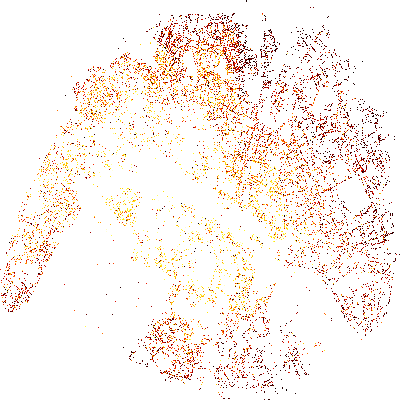

In [147]:
img

In [143]:
type(img)

datashader.transfer_functions.Image

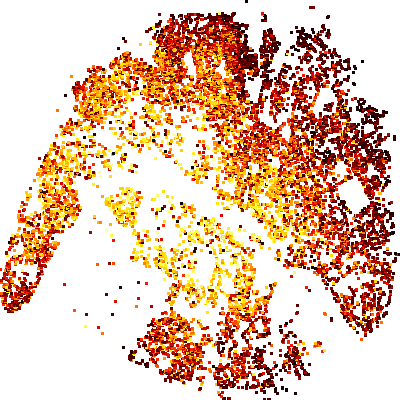

In [159]:
tf.spread(img, px=1, how='over')

In [0]:
tf.spread